In [5]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive

drive.mount('/content/drive')
# ---------- Load data ----------
in_path = Path("/content/drive/MyDrive/singapore_airlines_reviews.csv")
df = pd.read_csv(in_path)
df.columns = [c.strip() for c in df.columns]

# ---------- Combine title + text ----------
df["combined_review"] = (df["title"].fillna("") + " " + df["text"].fillna("")).str.strip()

# ---------- Proxy sentiment from rating ----------
def map_rating_to_sentiment(x):
    try:
        r = float(x)
    except Exception:
        return np.nan
    if r <= 2:  return "negative"
    if r >= 4:  return "positive"
    return "neutral"

df["sentiment_proxy"] = df["rating"].apply(map_rating_to_sentiment)

# ---------- Text cleaner ----------
emoji_pattern = re.compile(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)')
tag_pattern   = re.compile(r'<[^>]*>')
nonword_pat   = re.compile(r'[\W]+')

def preprocessor(text: str) -> str:
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    text = tag_pattern.sub('', text)
    emojis = emoji_pattern.findall(text)
    text = nonword_pat.sub(' ', text.lower()).strip()
    if emojis:
        text = text + ' ' + ' '.join(e.replace('-', '') for e in emojis)
    return text

# ---------- 70/10/20 split ----------
idx_all = np.arange(len(df))
y = df["sentiment_proxy"].values
strat_all = y if pd.Series(y).notna().all() else None

# 80% train+val vs 20% test
idx_trval, idx_test, y_trval, y_test = train_test_split(
    idx_all, y,
    test_size=0.20, random_state=42, stratify=strat_all
)

# From 80%, carve 10% total for val → 12.5% of trval
val_frac = 0.10 / 0.80
strat_trval = y_trval if pd.Series(y_trval).notna().all() else None

idx_train, idx_val, y_train, y_val = train_test_split(
    idx_trval, y_trval,
    test_size=val_frac, random_state=42, stratify=strat_trval
)

# ---------- Create 3 dataframes ----------
train_df = df.loc[idx_train].copy()
val_df   = df.loc[idx_val].copy()
test_df  = df.loc[idx_test].copy()

train_df["split"] = "train"
val_df["split"]   = "val"
test_df["split"]  = "test"

# ---------- TF-IDF (fit on train only) ----------
vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)
X_train_tfidf = vectorizer.fit_transform(train_df["combined_review"].astype(str))
X_val_tfidf   = vectorizer.transform(val_df["combined_review"].astype(str))
X_test_tfidf  = vectorizer.transform(test_df["combined_review"].astype(str))

# ---------- Summary ----------
summary = {
    "n_total": len(df),
    "n_train": len(train_df),
    "n_val":   len(val_df),
    "n_test":  len(test_df),
    "n_features": X_train_tfidf.shape[1],
    "train_class_counts": Counter(train_df["sentiment_proxy"]),
    "val_class_counts":   Counter(val_df["sentiment_proxy"]),
    "test_class_counts":  Counter(test_df["sentiment_proxy"])
}

print("Split summary:")
for k, v in summary.items():
    print(f"{k}: {v}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Split summary:
n_total: 10000
n_train: 7000
n_val: 1000
n_test: 2000
n_features: 42199
train_class_counts: Counter({'positive': 5174, 'negative': 1120, 'neutral': 706})
val_class_counts: Counter({'positive': 739, 'negative': 160, 'neutral': 101})
test_class_counts: Counter({'positive': 1478, 'negative': 320, 'neutral': 202})


✨ Positive reviews word cloud:


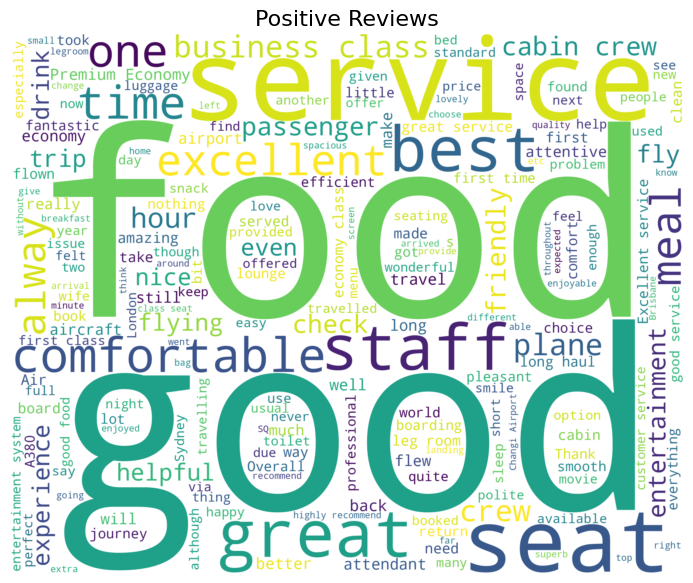

💀 Negative reviews word cloud:


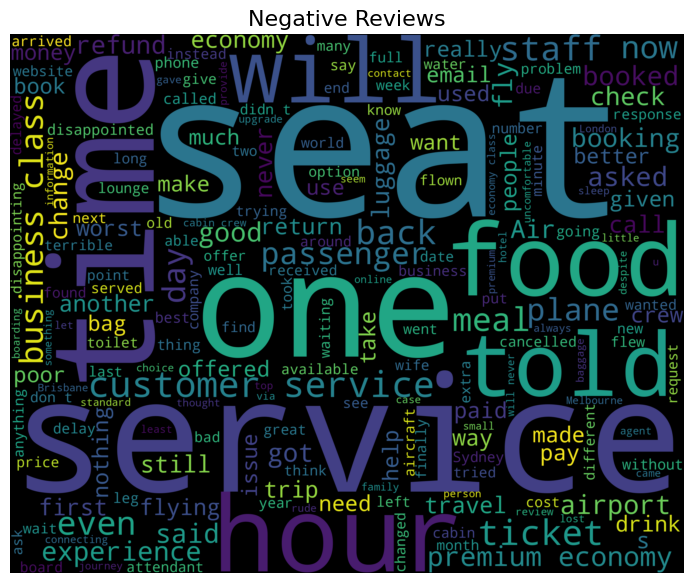

😐 Neutral reviews word cloud:


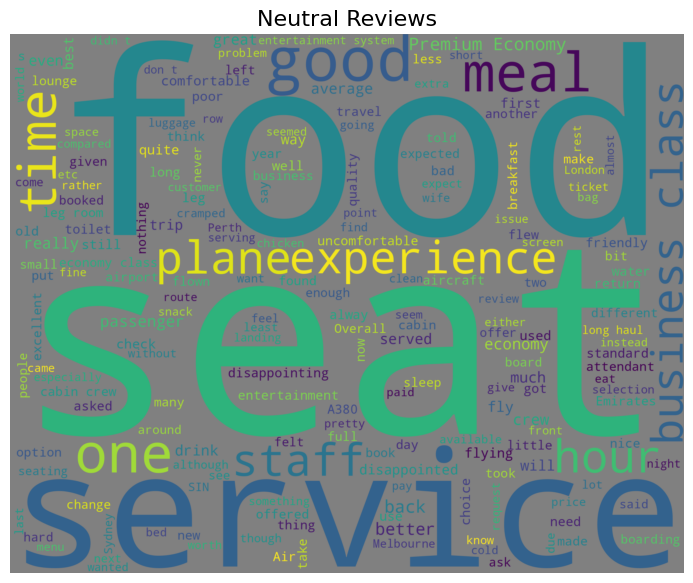

In [6]:
#Word Clouds
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re

# --- Split dataset by sentiment ---
pos_reviews = df[df["sentiment_proxy"] == "positive"]["combined_review"]
neg_reviews = df[df["sentiment_proxy"] == "negative"]["combined_review"]
neu_reviews = df[df["sentiment_proxy"] == "neutral"]["combined_review"]

# --- Define stopwords and wordcloud generator ---
stop = set(STOPWORDS)

def wordcloud_draw(data, color='white', title='Word Cloud'):
    words = ' '.join(data.dropna().astype(str))  # Combine text
    words = re.sub(r'(?:singapore|airlines|flight|airline|sia|flight)', '', words, flags=re.IGNORECASE)
    cleaned_words = " ".join([word for word in words.split() if len(word) > 2])

    wordcloud = WordCloud(
        stopwords=stop,
        background_color=color,
        width=2500,
        height=2000,
        max_words=200
    ).generate(cleaned_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# --- Generate the word clouds ---
print("✨ Positive reviews word cloud:")
wordcloud_draw(pos_reviews, color='white', title='Positive Reviews')

print("💀 Negative reviews word cloud:")
wordcloud_draw(neg_reviews, color='black', title='Negative Reviews')

print("😐 Neutral reviews word cloud:")
wordcloud_draw(neu_reviews, color='gray', title='Neutral Reviews')


Validation Accuracy: 0.8620
Test Accuracy: 0.8615

Classification Report (Validation):
              precision    recall  f1-score   support

    negative      0.788     0.719     0.752       160
     neutral      0.528     0.277     0.364       101
    positive      0.898     0.973     0.934       739

    accuracy                          0.862      1000
   macro avg      0.738     0.656     0.683      1000
weighted avg      0.843     0.862     0.847      1000


Classification Report (Test):
              precision    recall  f1-score   support

    negative      0.751     0.734     0.742       320
     neutral      0.526     0.252     0.341       202
    positive      0.904     0.972     0.937      1478

    accuracy                          0.862      2000
   macro avg      0.727     0.653     0.673      2000
weighted avg      0.841     0.862     0.846      2000



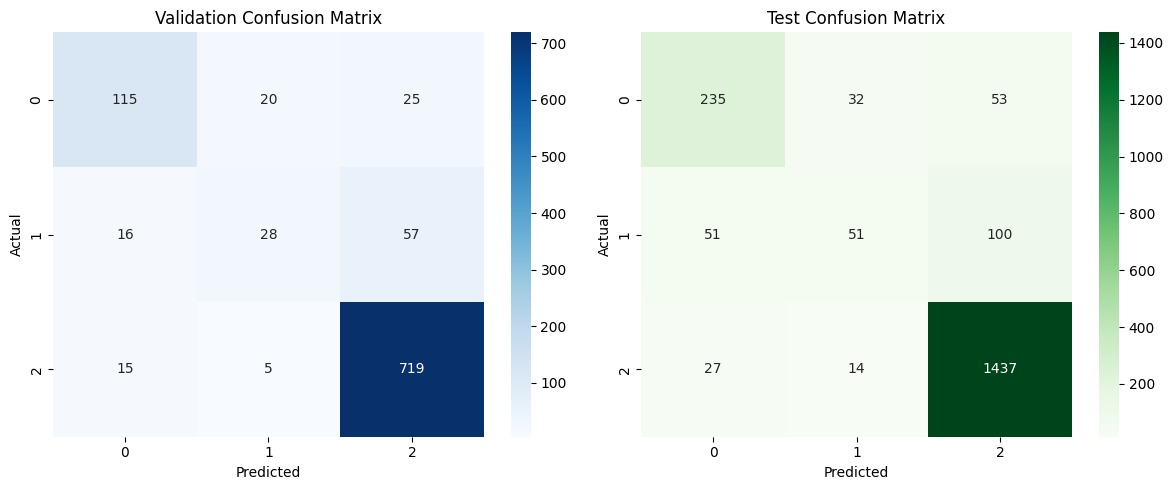

In [7]:
#SVM
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Train Linear SVM ----------
svm_clf = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=0.0001,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    shuffle=True,
    random_state=42,
    learning_rate='optimal'
)

svm_clf.fit(X_train_tfidf, y_train)

# ---------- Validation evaluation ----------
y_val_pred = svm_clf.predict(X_val_tfidf)
val_acc = metrics.accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# ---------- Test evaluation ----------
y_test_pred = svm_clf.predict(X_test_tfidf)
test_acc = metrics.accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# ---------- Detailed metrics ----------
print("\nClassification Report (Validation):")
print(metrics.classification_report(y_val, y_val_pred, digits=3))

print("\nClassification Report (Test):")
print(metrics.classification_report(y_test, y_test_pred, digits=3))

# ---------- Confusion matrix ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Validation confusion matrix
sns.heatmap(metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Validation Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

# Test confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title("Test Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()
